# NTSB demo

Sycamore is a **Document Processing System** = **ETL** + **Query Planning/Retrieval**.

https://aryn-public.s3.amazonaws.com/ntsb/22.pdf

**ETL steps**:
- extract Text + Structure: titles, section headers, text paragraphs, figures, tables and their cells, captions, page headers and footers, footnotes
- summarize images
- extract data from tables
- standardize locations and dates

**Query Planning/Retrieval**:
Having these structural elements and information extracted enables the consumer of these document to have much better control over what is being embedded and how, leading to better retrieval in a RAG system.
For example, we can focus the retrieval on certain sections or eliminate them altogether.

**Question answering**:
Sycamore can also extract information from a document. We’ll see how it can extract location and dates from NTSB docs, but also specific elements like aircraft type.  

Once the data is transformed, we can ask questions on it.

In [16]:
import sycamore 
from sycamore.transforms.partition import ArynPartitioner
from sycamore.transforms.summarize_images import SummarizeImages
from sycamore.transforms import (AssignDocProperties, 
                                ExtractTableProperties, 
                                StandardizeProperty, 
                                LocationStandardizer,
                                DateTimeStandardizer)

from sycamore.llms import OpenAI 
from sycamore.utils.aryn_config import ArynConfig, _DEFAULT_PATH
from sycamore.utils.pdf_utils import show_pages, enumerate_images_and_tables, display_page_and_table_properties
from sycamore.materialize import MaterializeSourceMode  
import json
from pathlib import Path

In [17]:
assert ArynConfig.get_aryn_api_key() != "", f"Unable to find aryn API key.  Looked in {_DEFAULT_PATH}"

In [18]:
ctx = sycamore.init()

In [21]:
s3_path = "s3://aryn-public/ntsb/22.pdf"
llm = OpenAI("gpt-4o-mini")
materialize_dir = Path.cwd() / "cache"


In [22]:
# Create a docset from segmented PDFs, extract tables, summarize images
docset = (
    ctx.read.binary(s3_path, binary_format="pdf")

    # Partition and extract tables and images
    .partition(ArynPartitioner(
                               extract_table_structure=True,
                               use_ocr=True, 
                               extract_images=True)
              )
    
    # Summarize each image element
    .transform(SummarizeImages)

    # Materialize each document
    .materialize(
        path=f"{materialize_dir}/docset_summarized",
        source_mode=MaterializeSourceMode.IF_PRESENT)
)

2024-09-09 00:01:46,480	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-09-09 00:01:46,487	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-08_23-59-32_761617_27333/logs/ray-data
2024-09-09 00:01:46,488	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> ActorPoolMapOperator[Map(BinaryScan._to_document)->MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(summarize_all_images)->MapBatches(materialize)->MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=25] -> TaskPoolMapOperator[MapBatches(DrawBoxes)]


- ReadBinary->SplitBlocks(8) 1:   0%|                                                                         …

- Map(BinaryScan._to_document)->MapBatches(BaseMapTransformCallable___wrap) 2:   0%|                          …

- MapBatches(summarize_all_images)->MapBatches(materialize)->MapBatches(split_and_convert_to_image) 3:   0%|  …

- limit=25 4:   0%|                                                                                           …

- MapBatches(DrawBoxes) 5:   0%|                                                                              …

Running 0:   0%|                                                                                              …

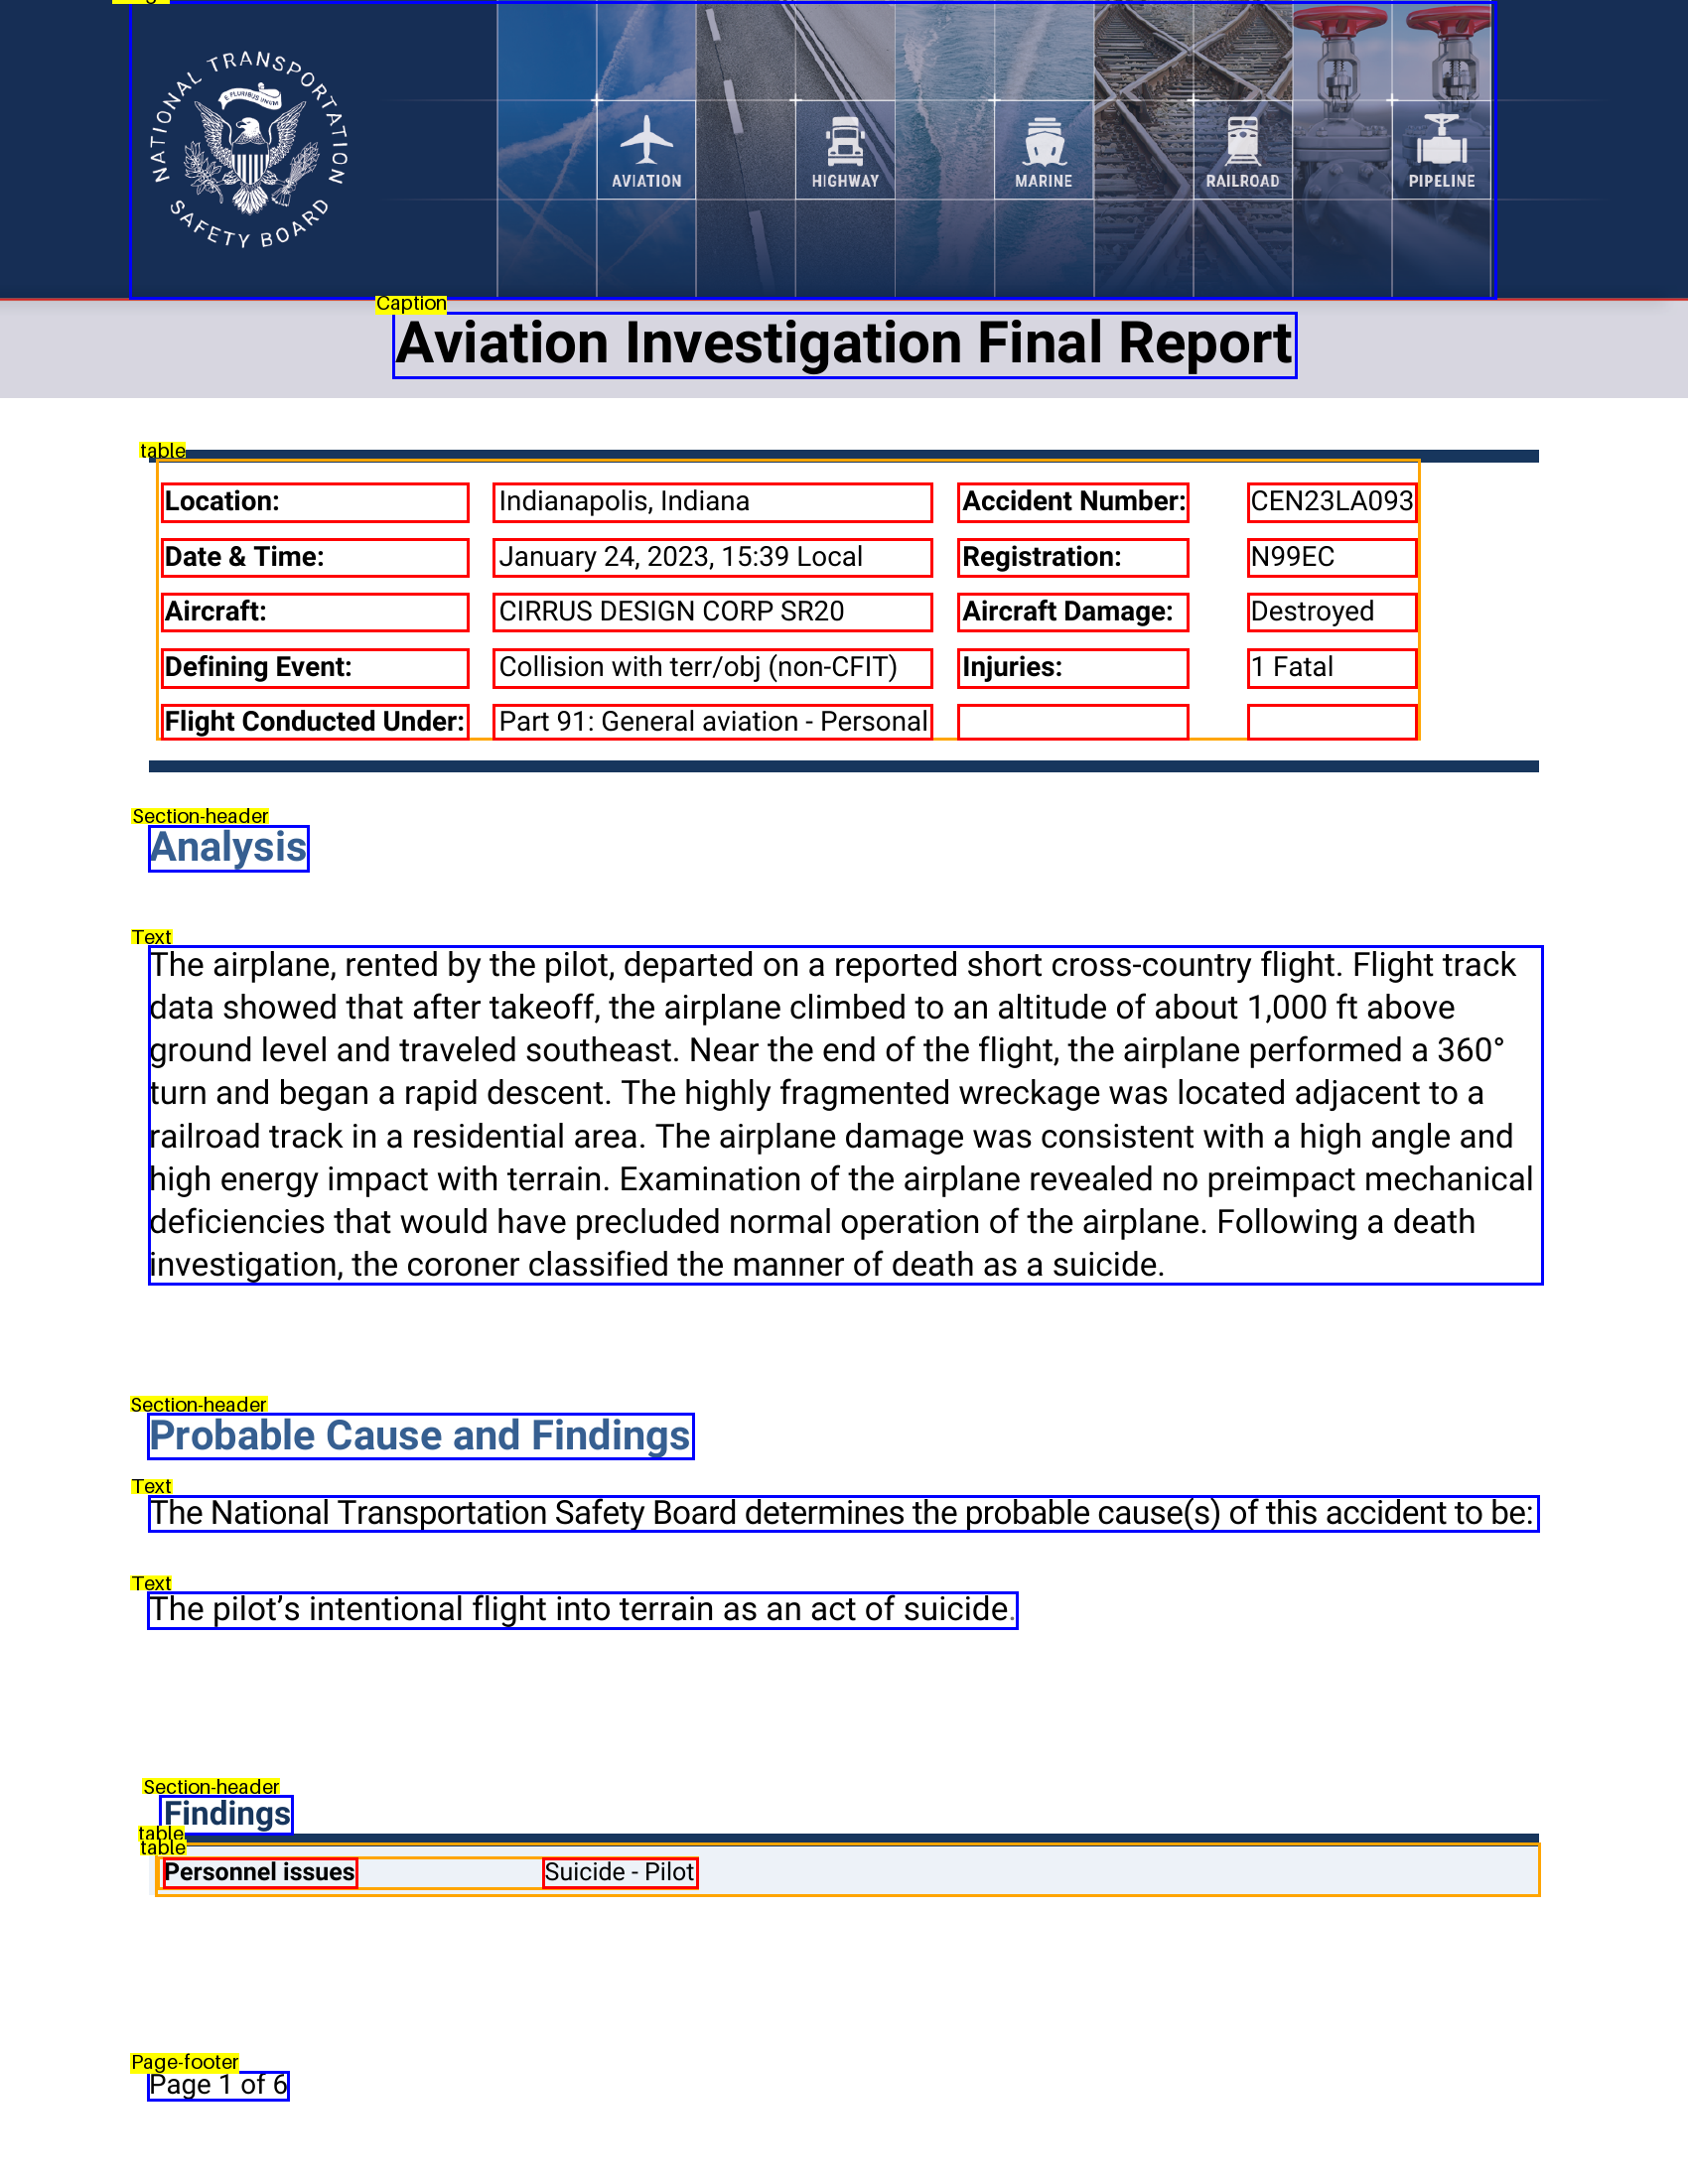

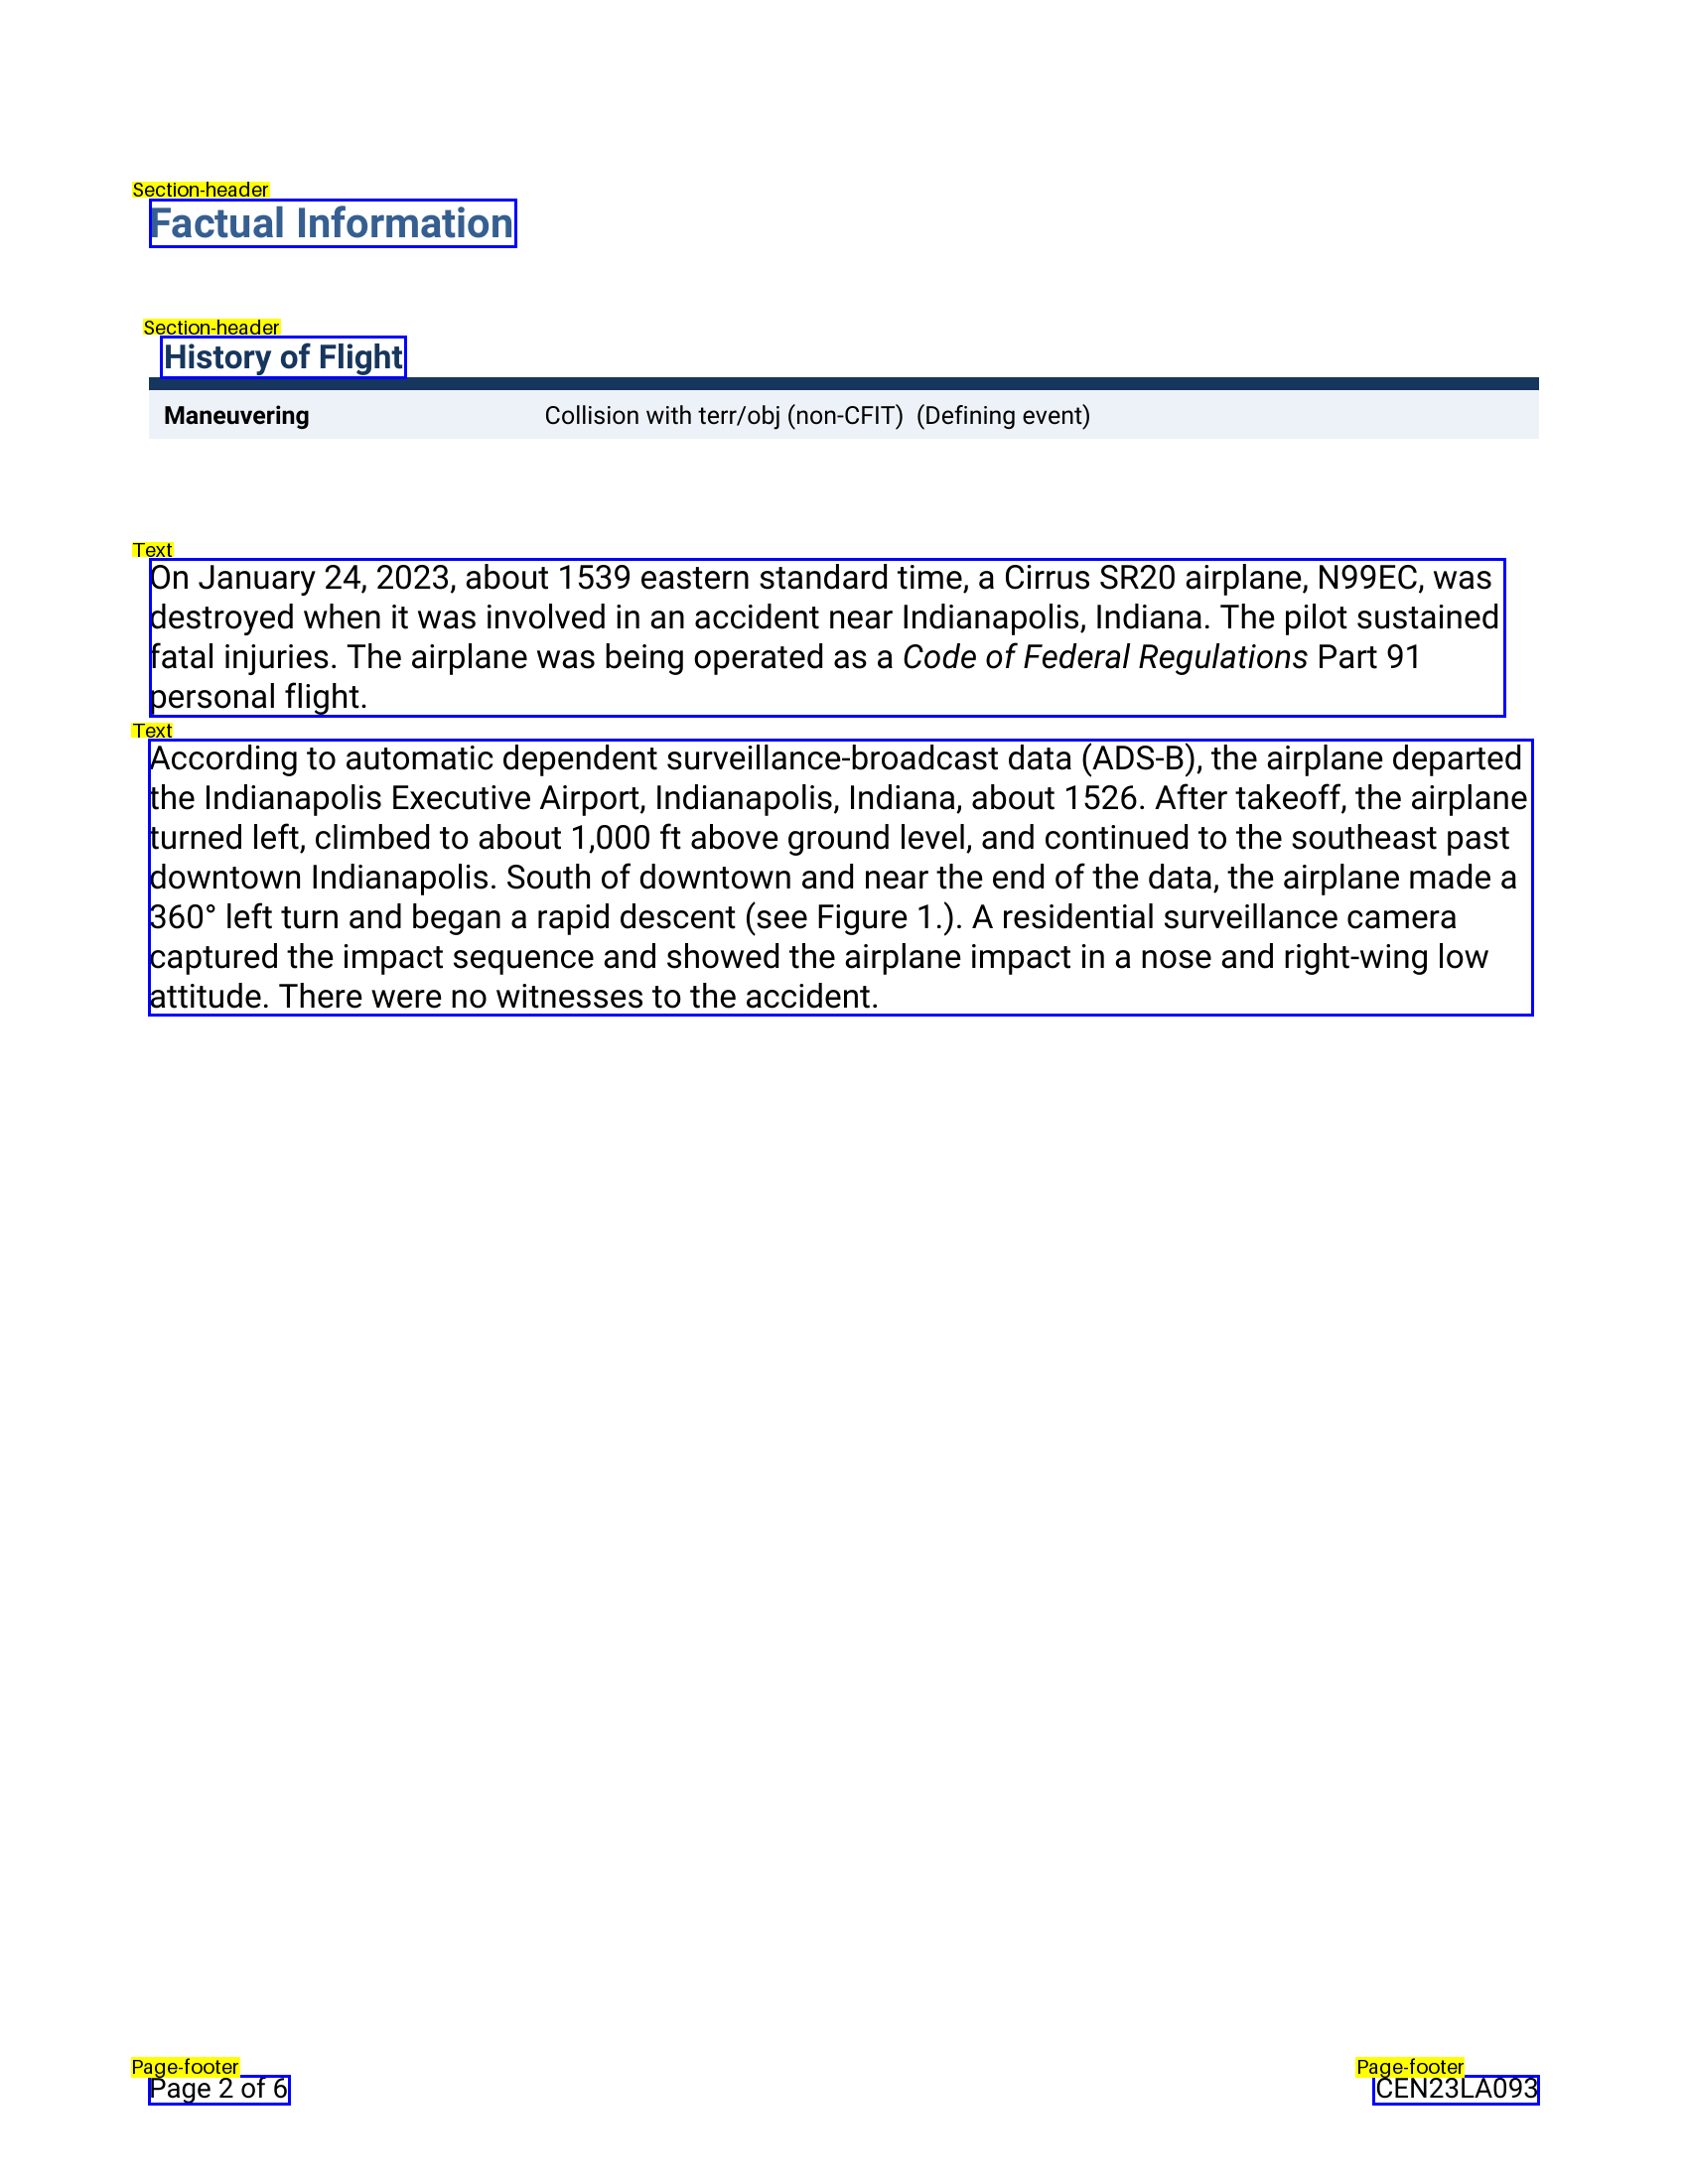

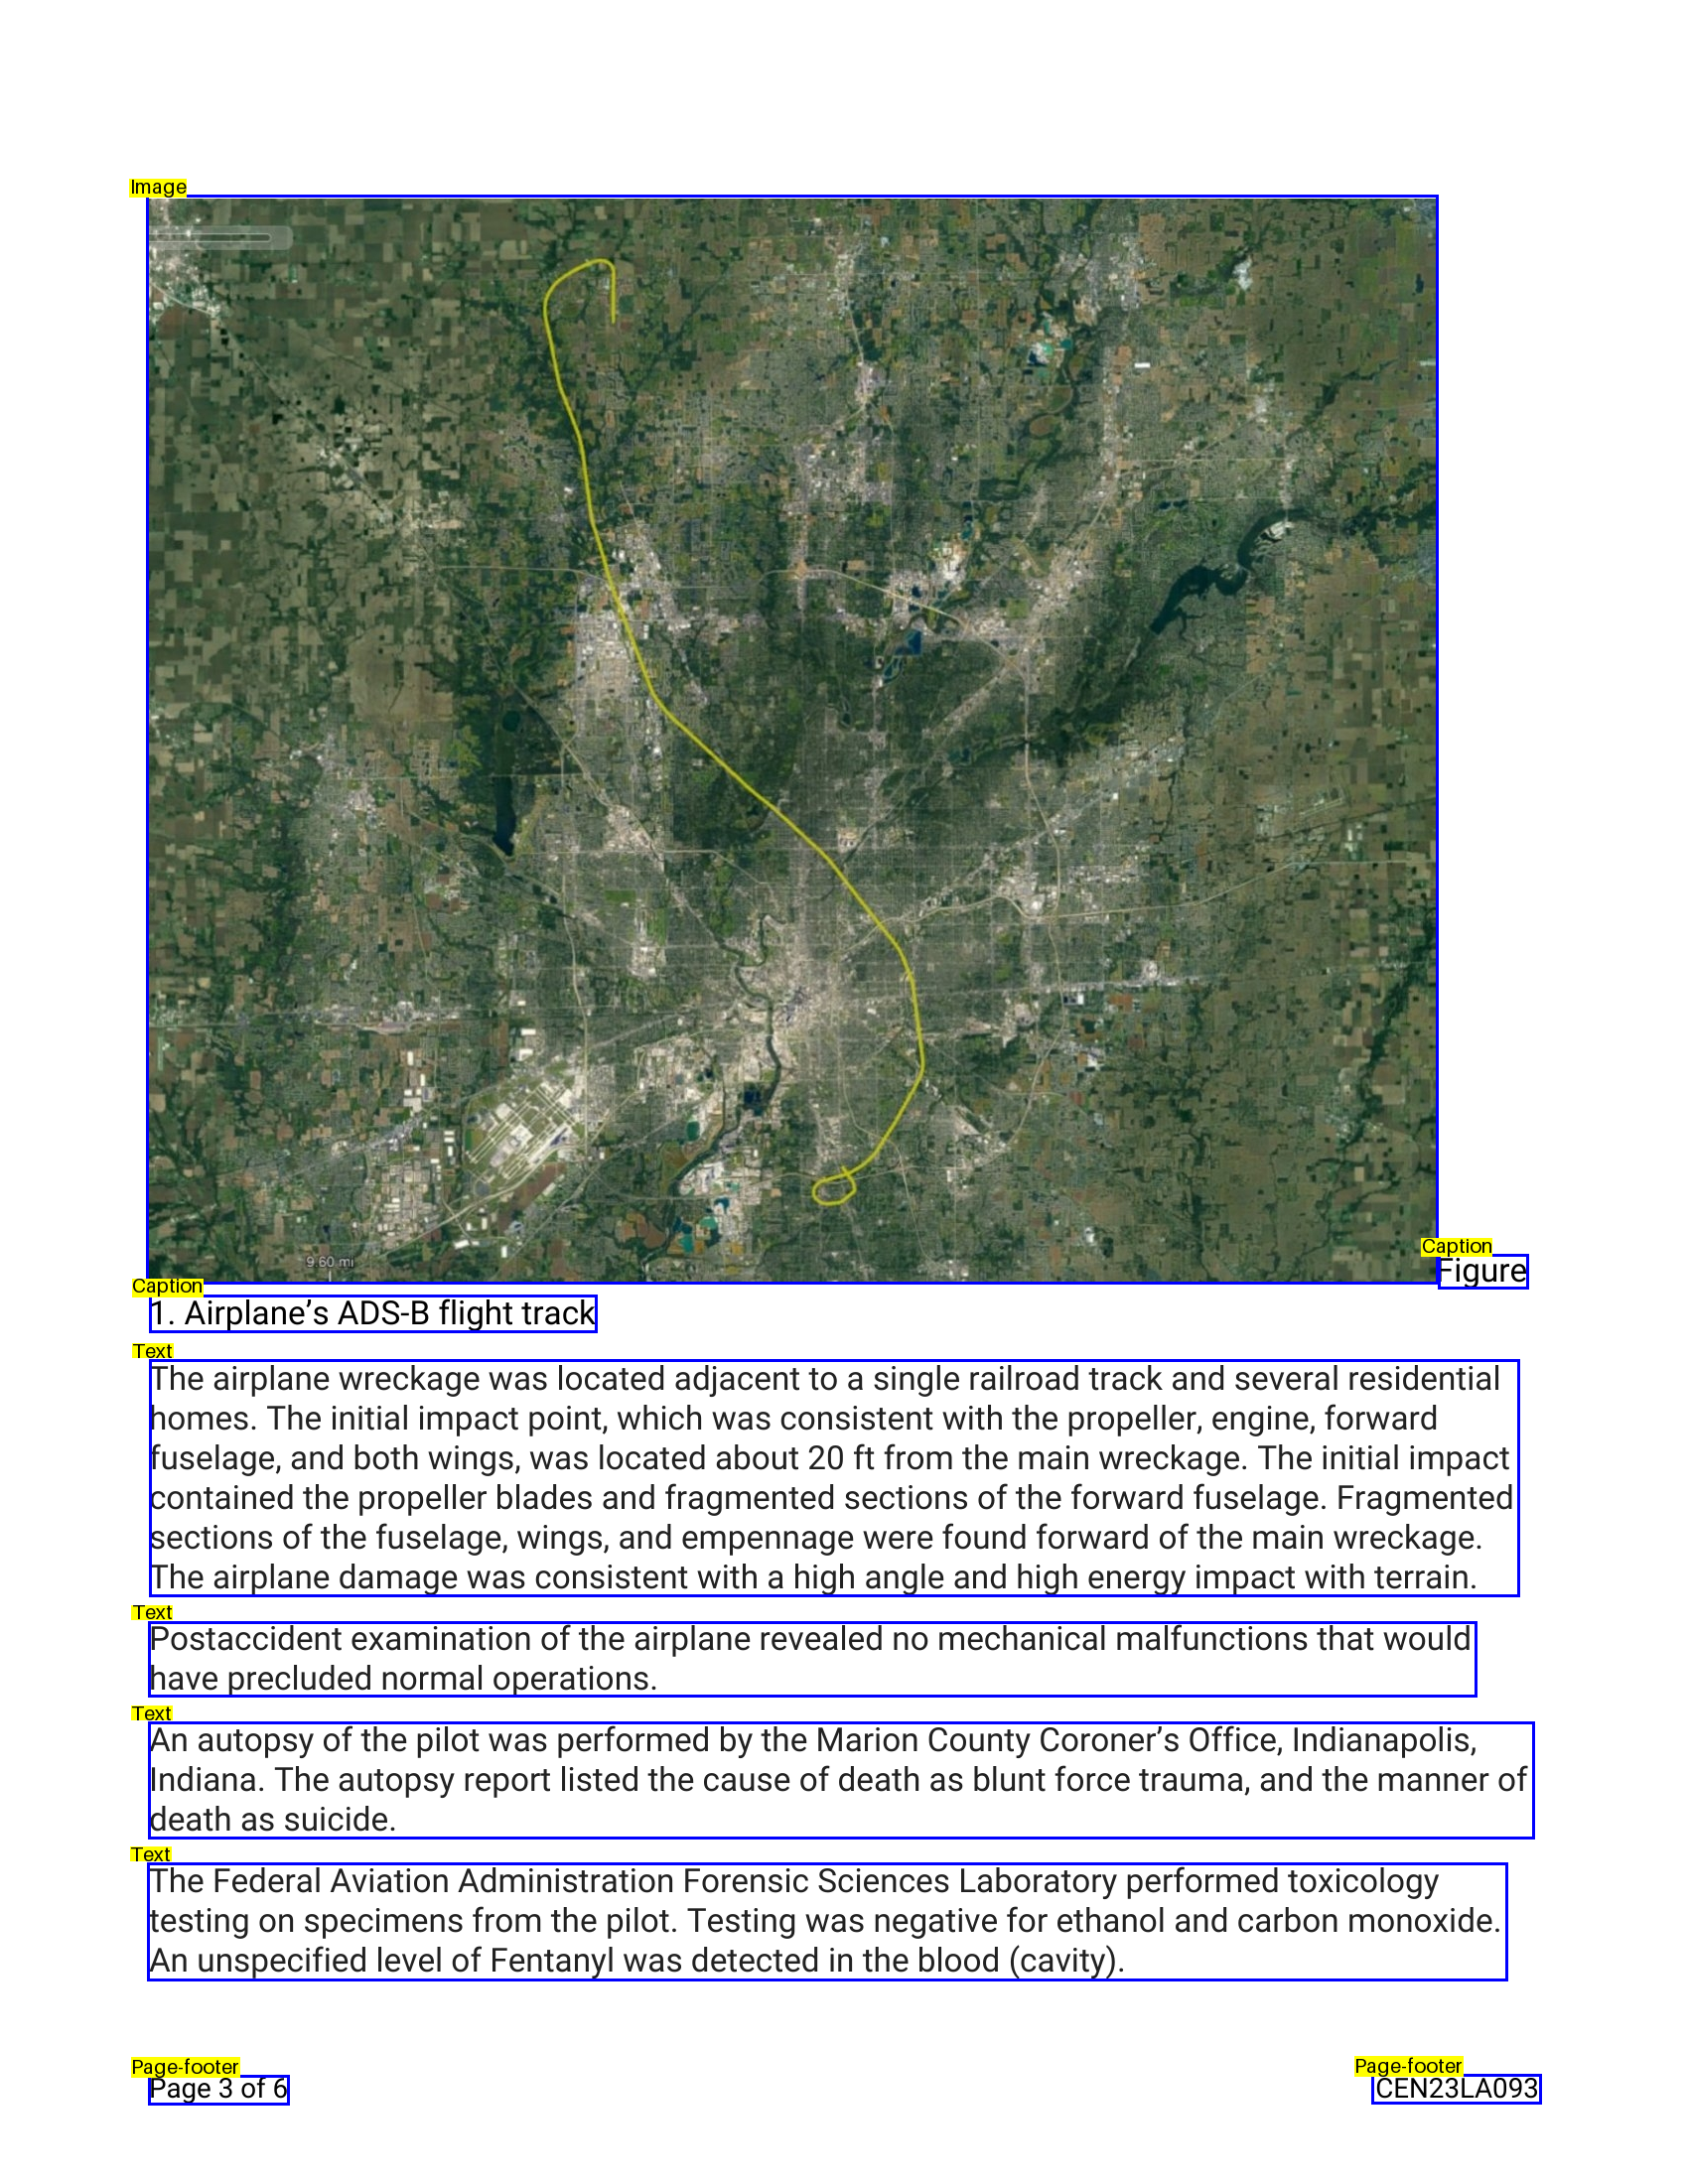

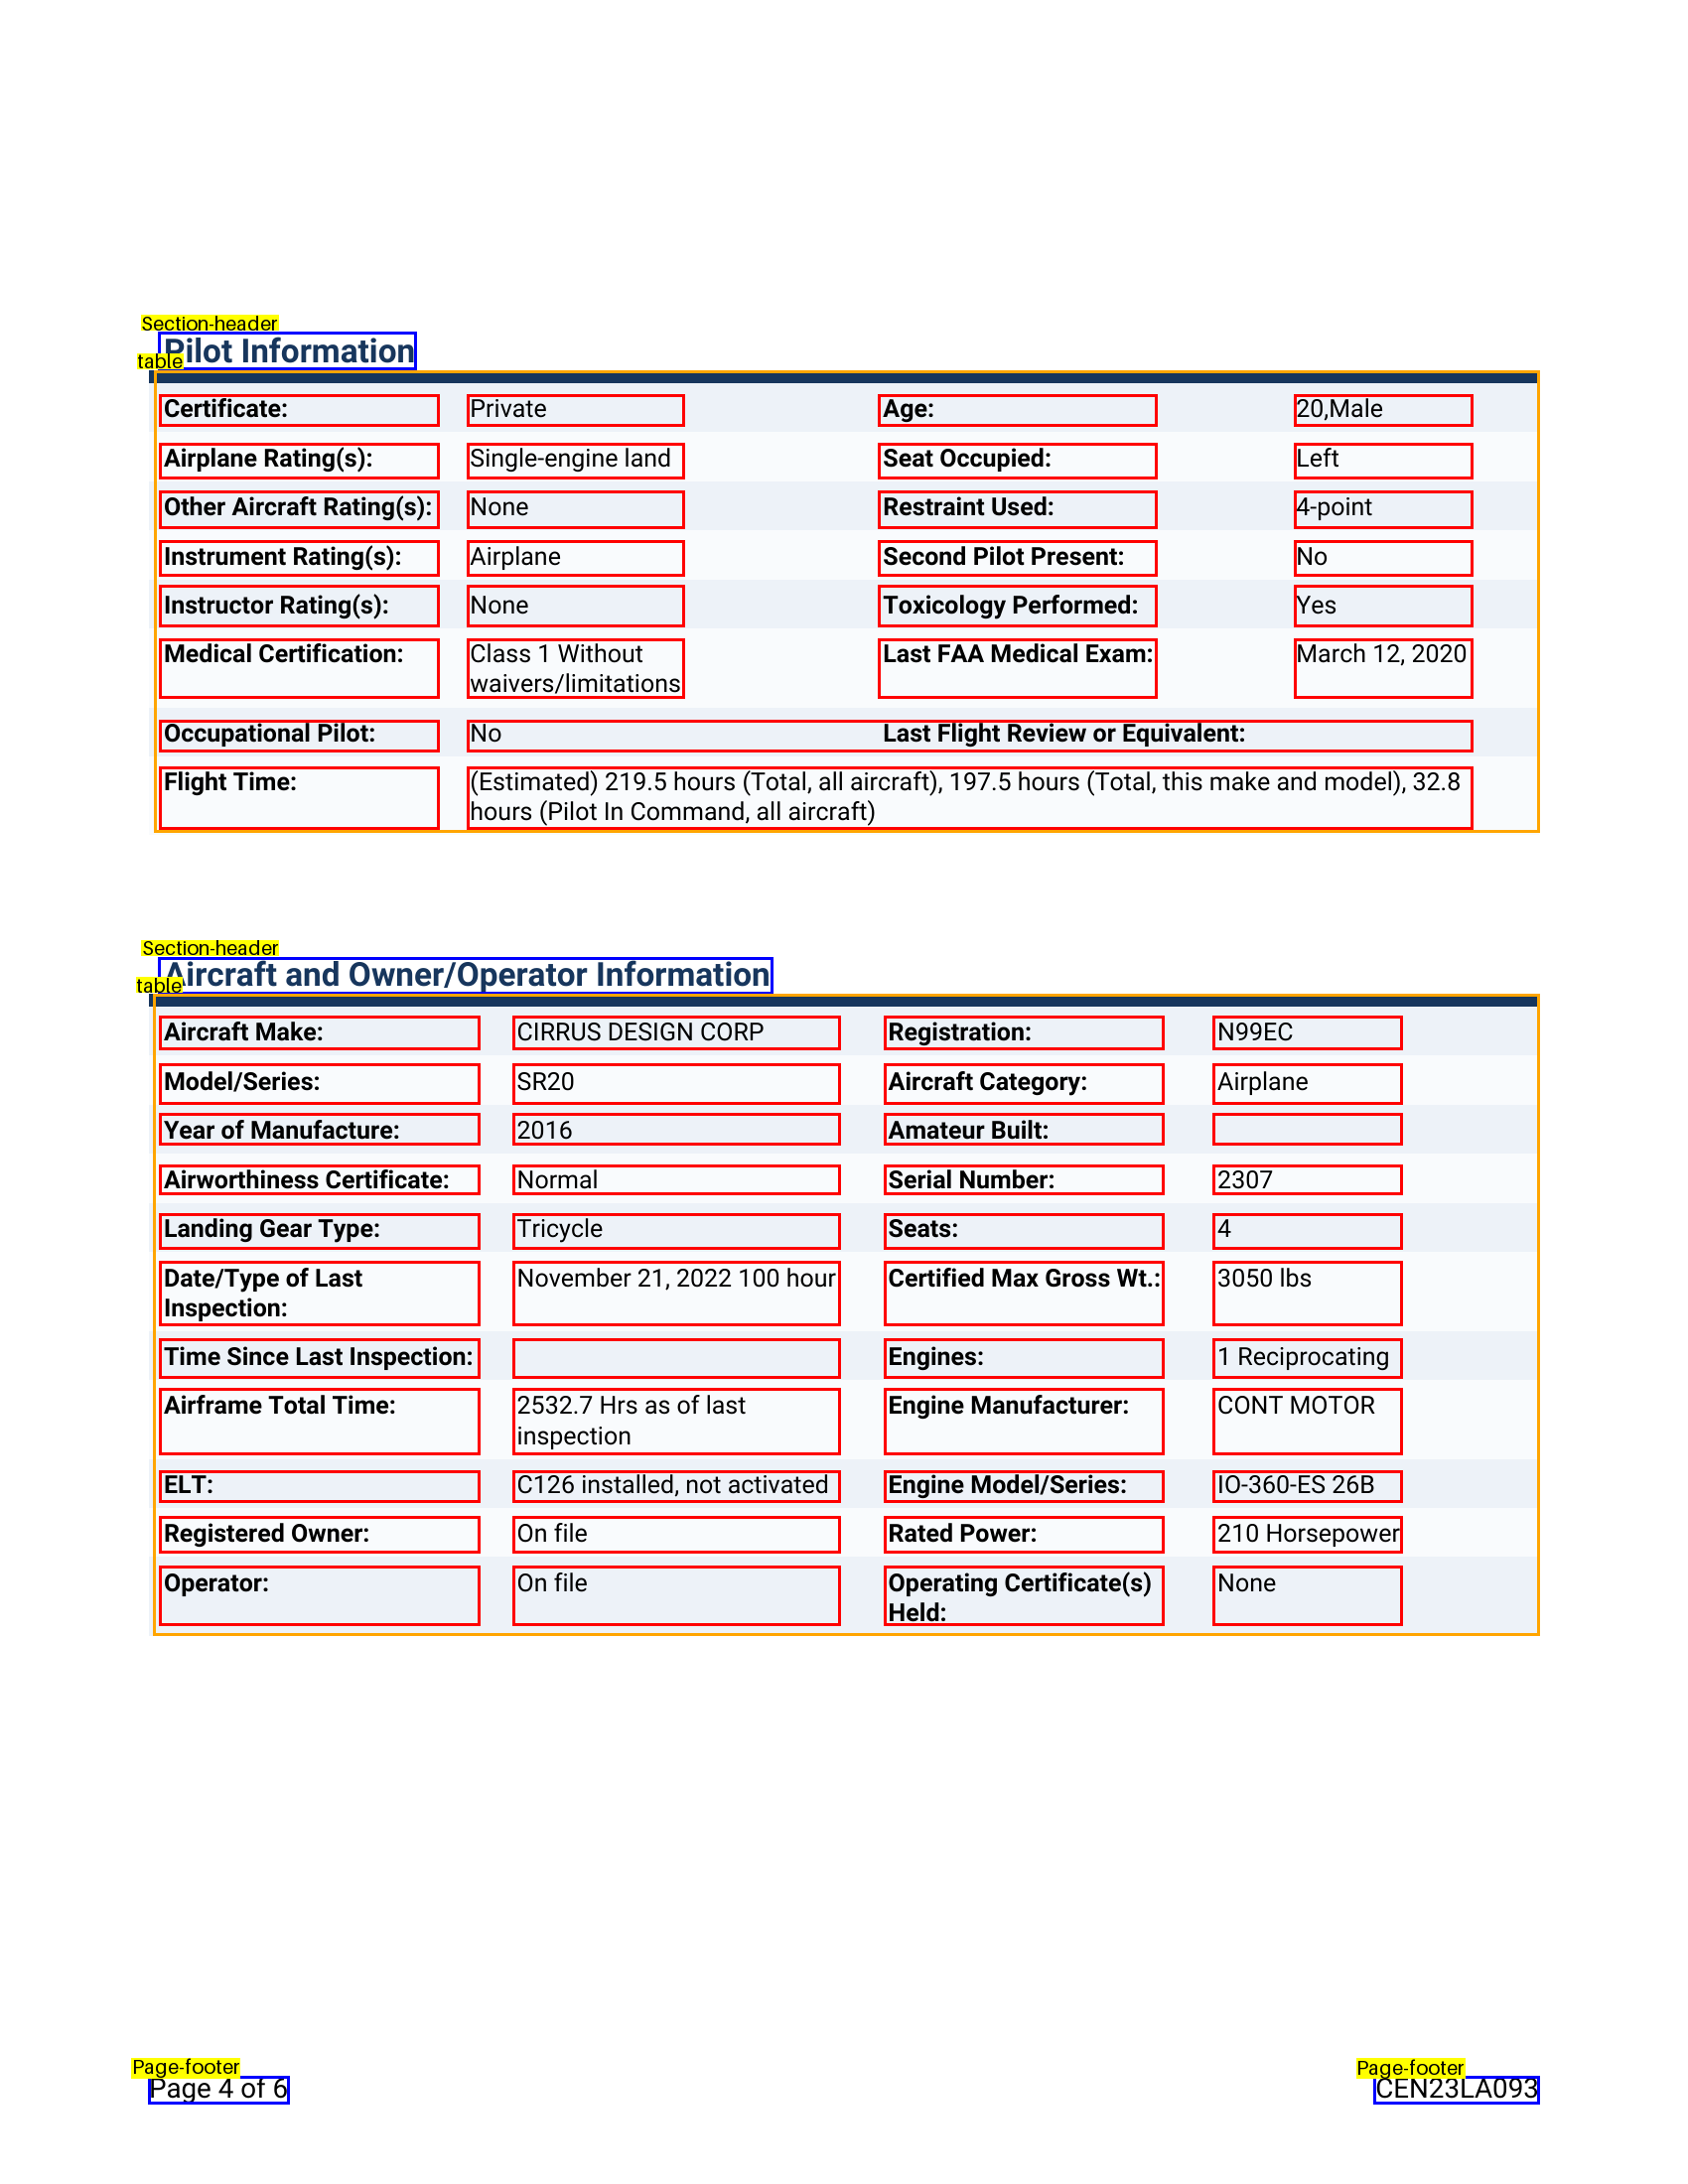

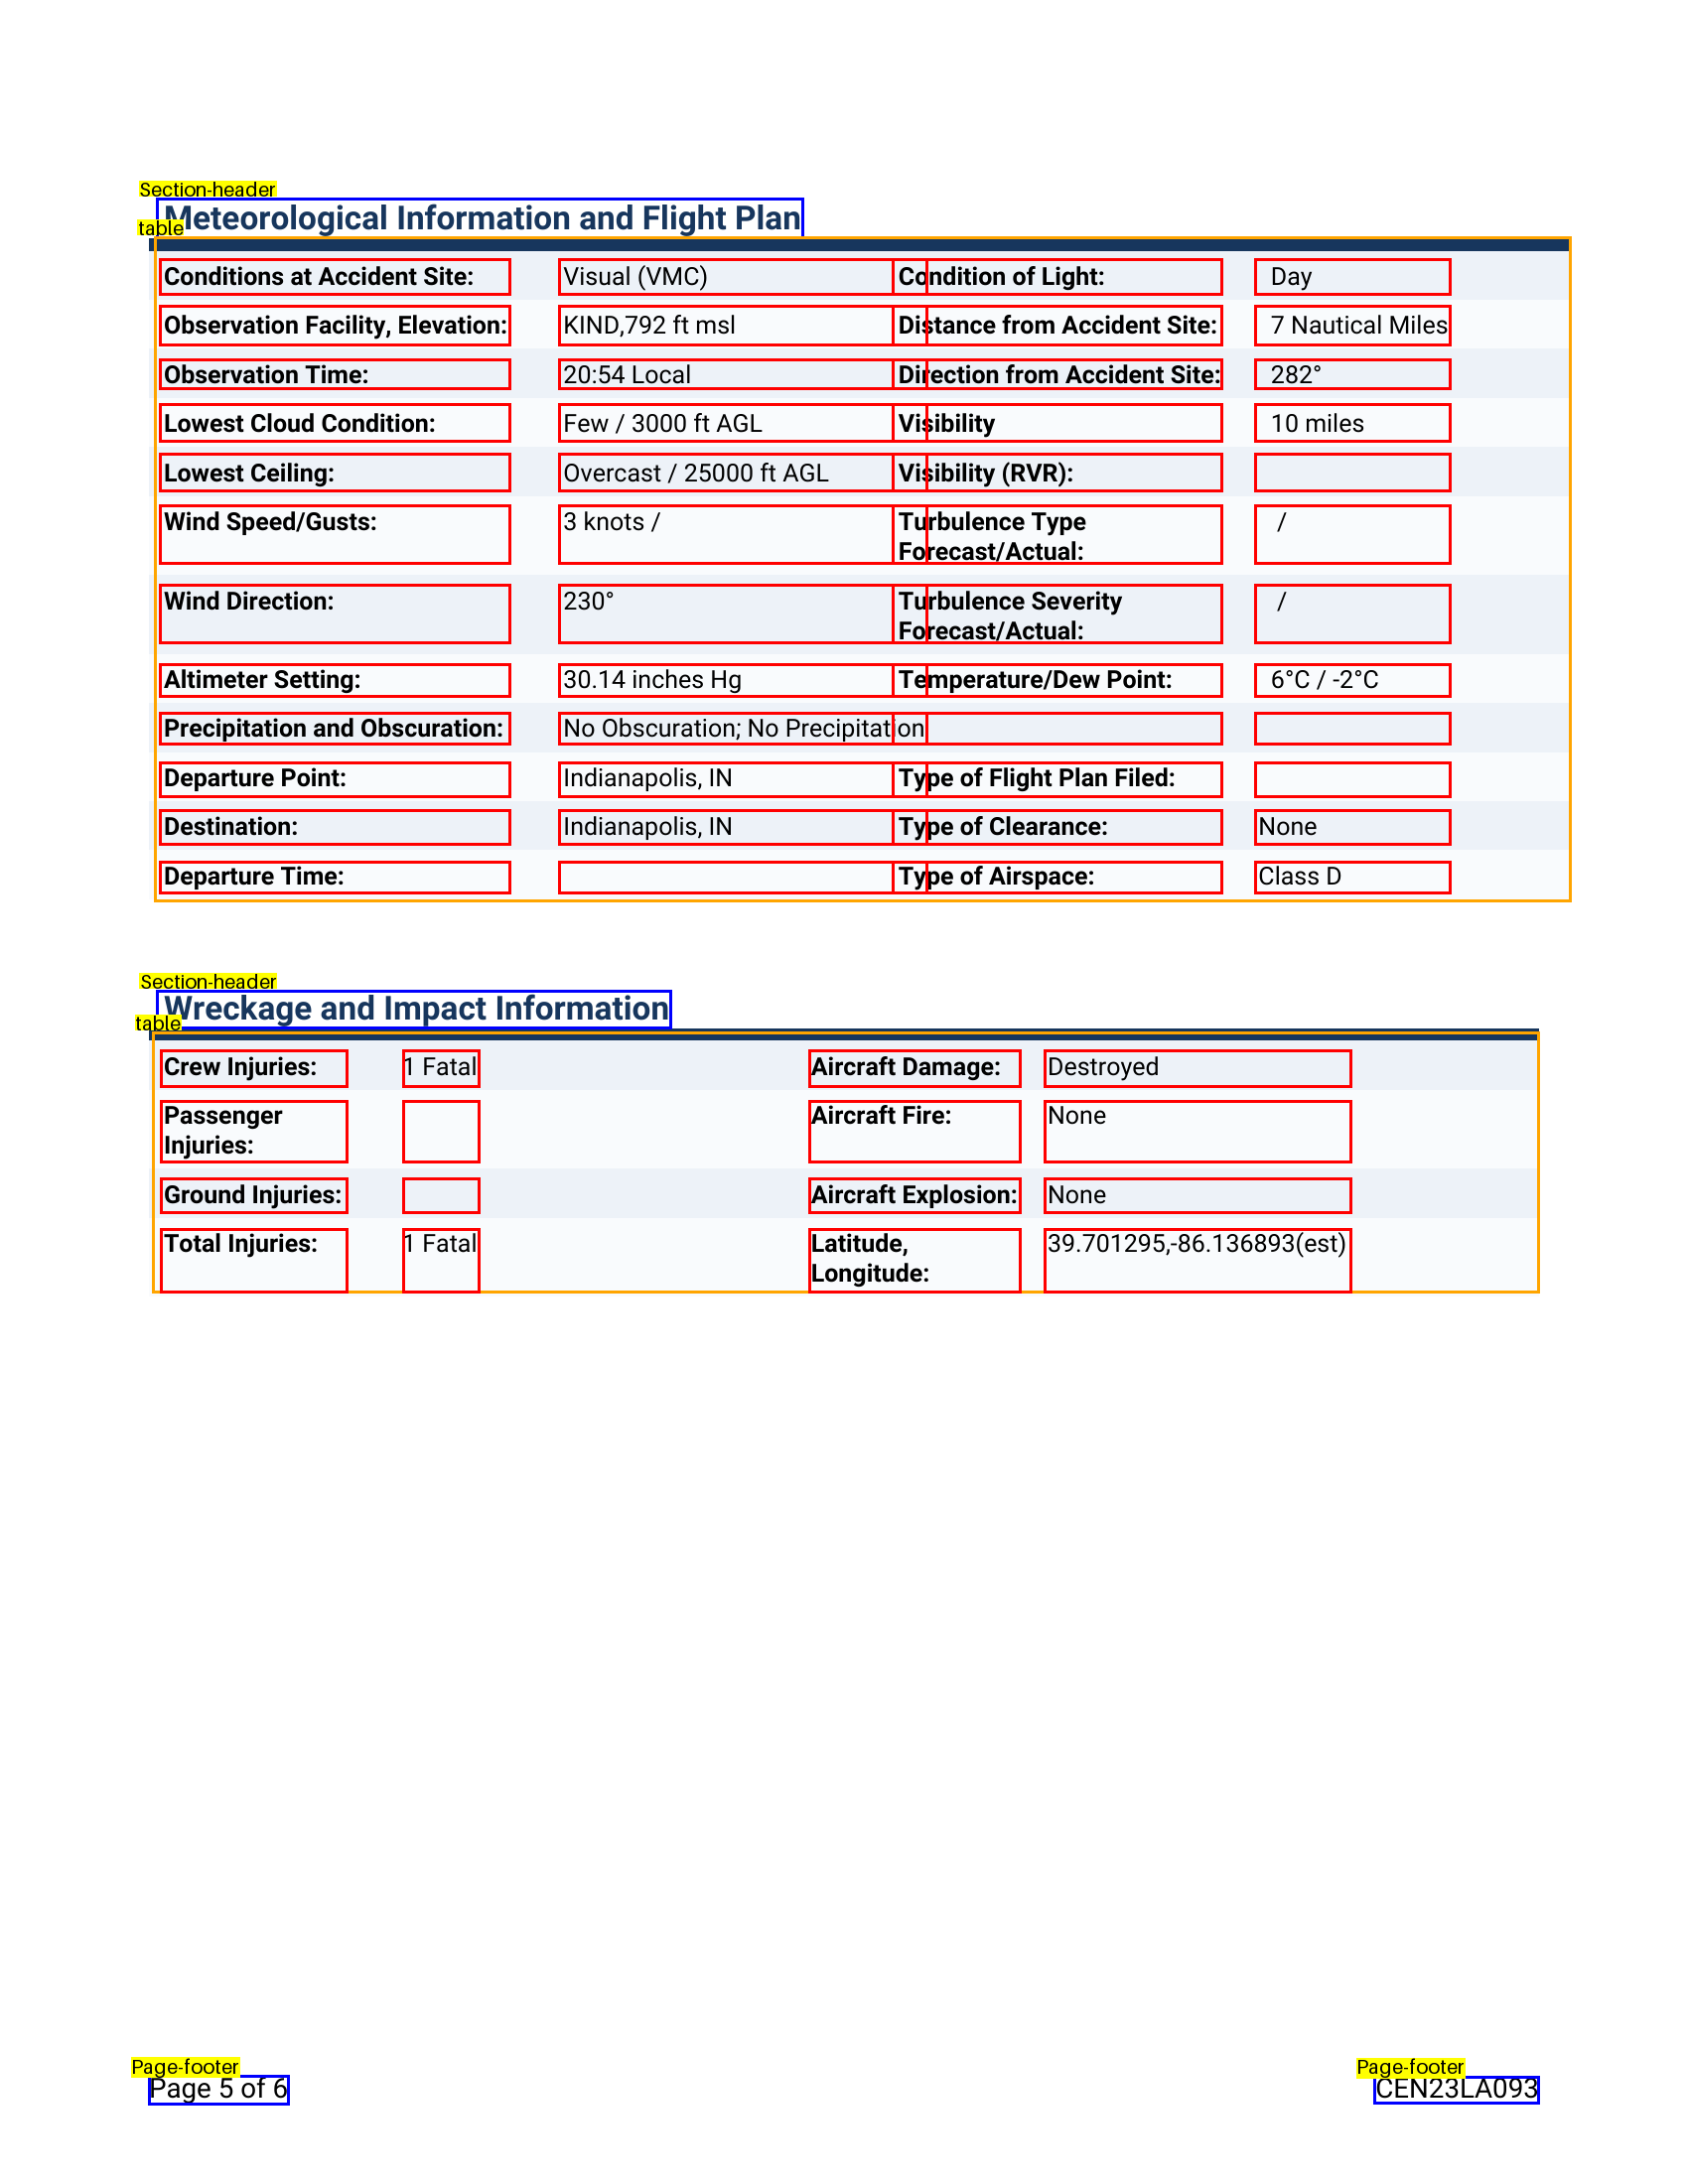

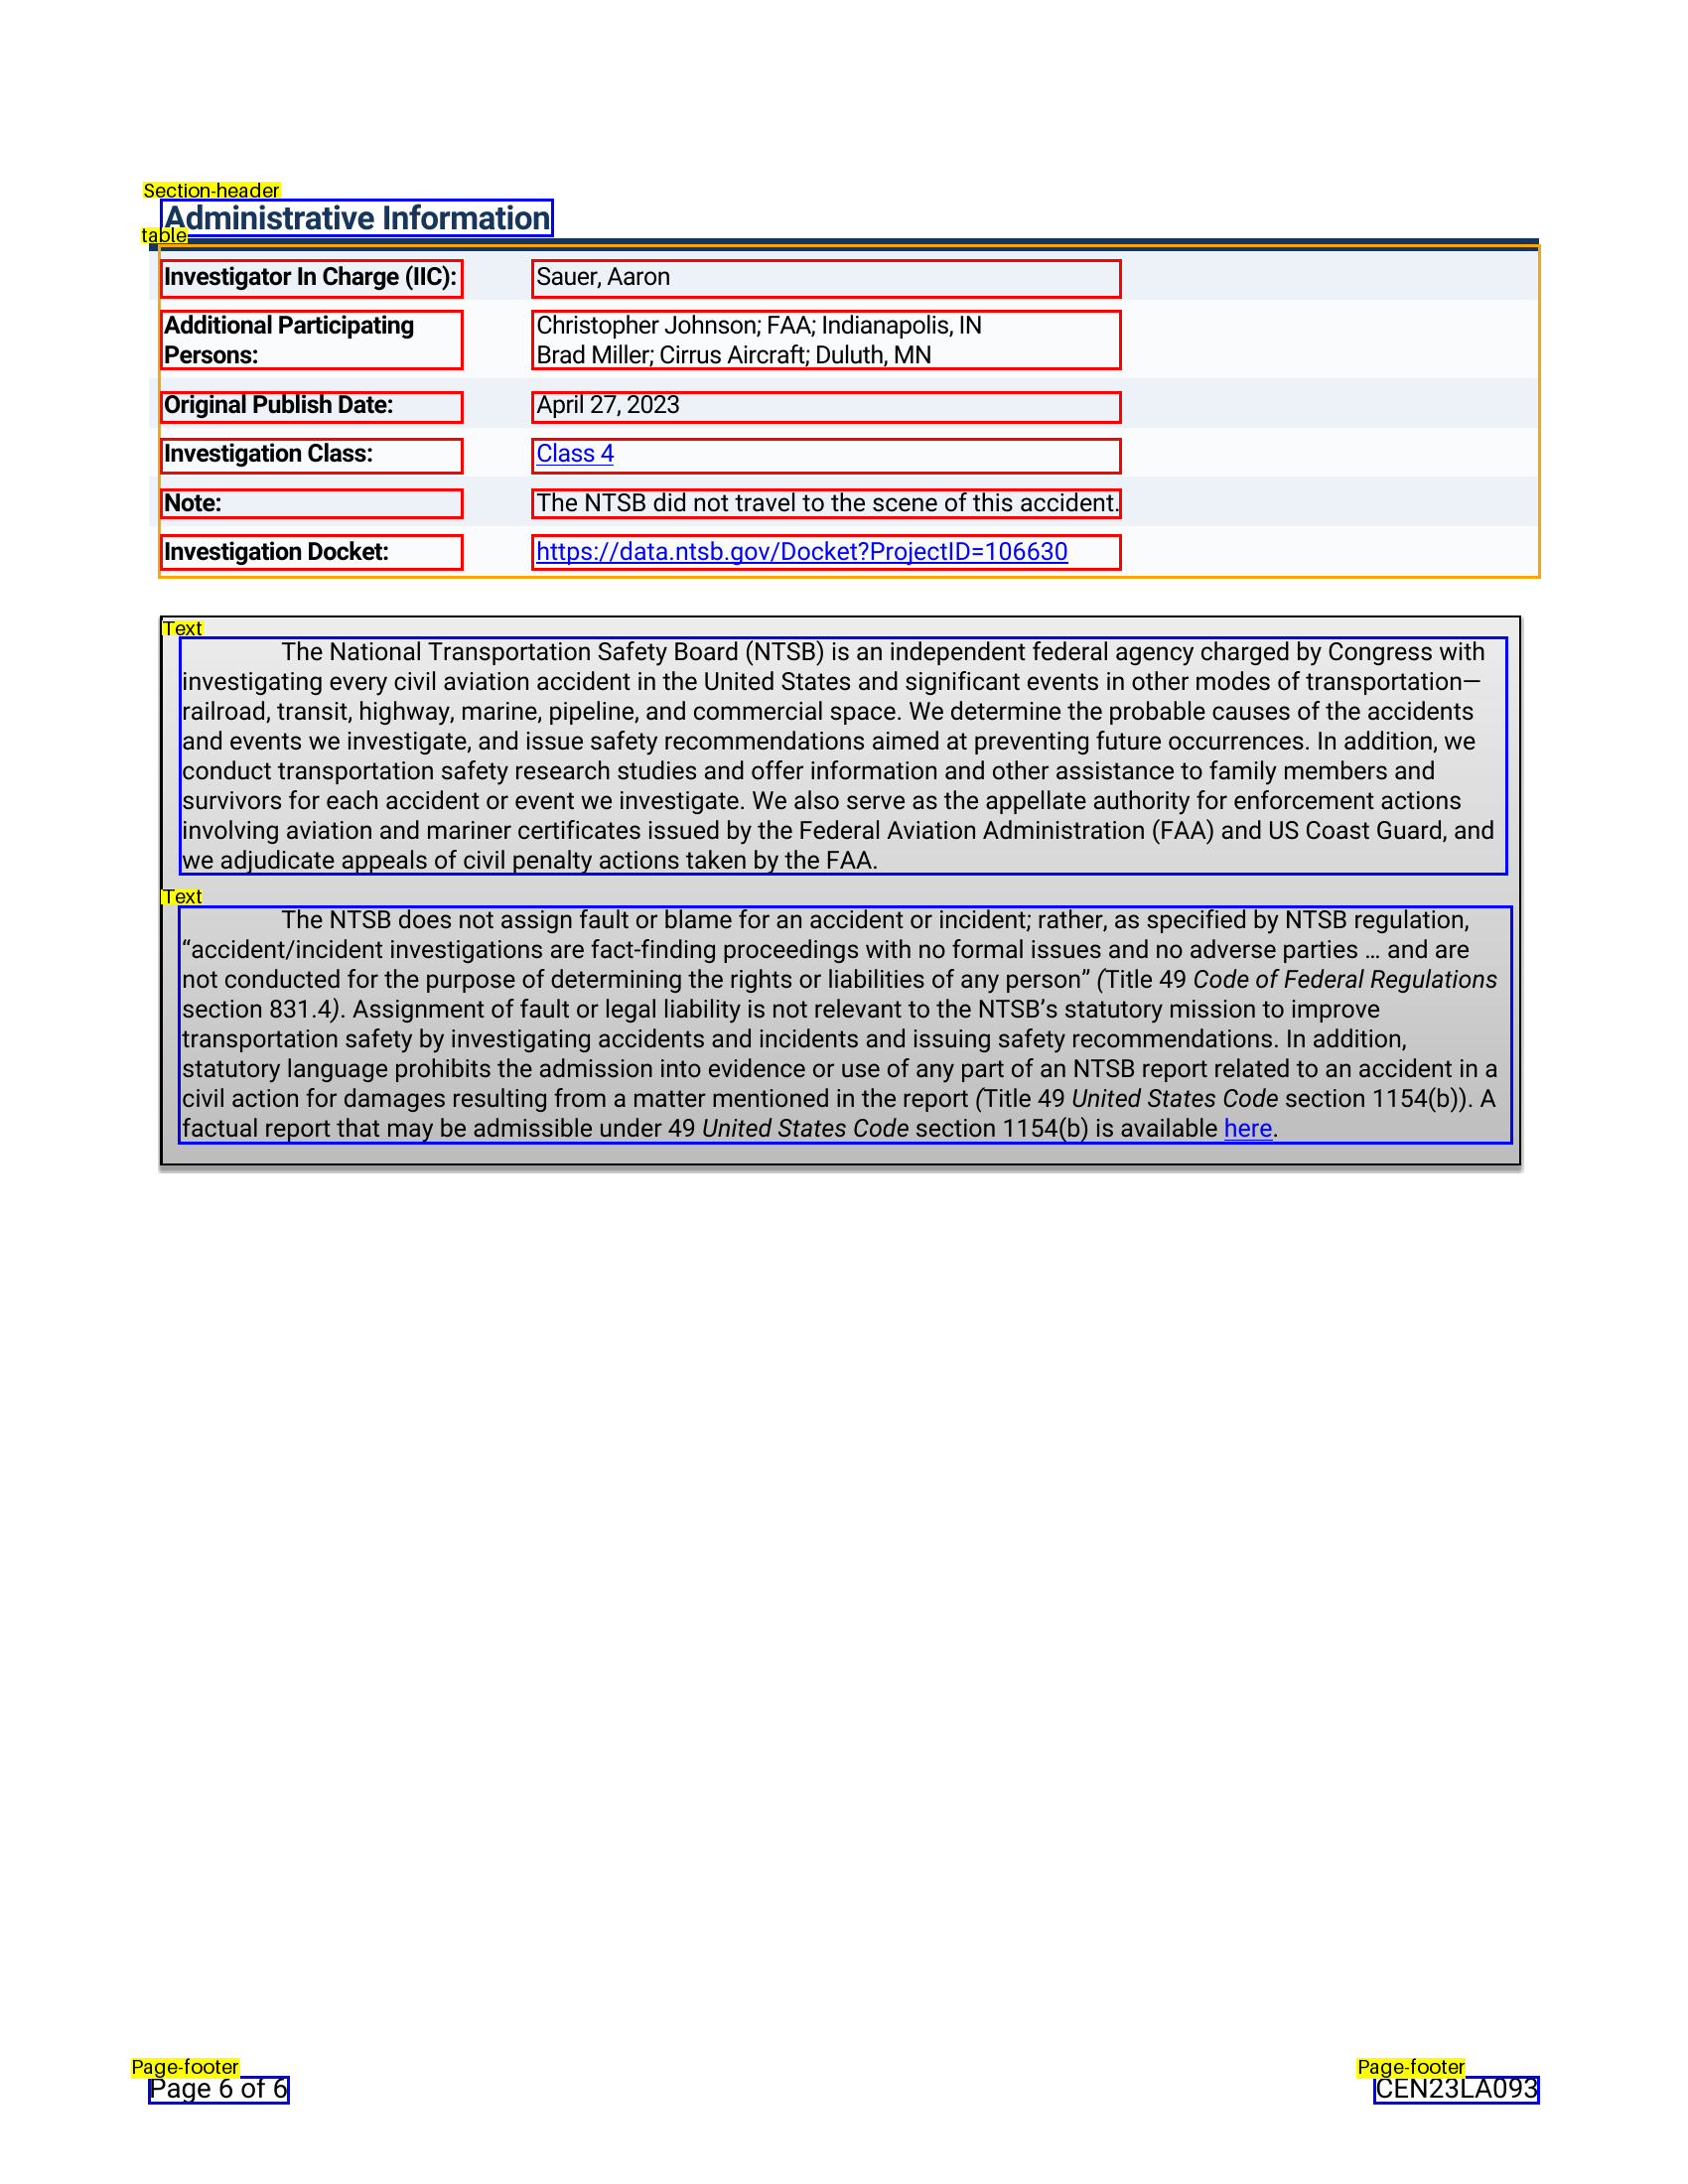

In [23]:
show_pages(docset, limit=25)

In [24]:
enumerate_images_and_tables(docset.take_all())

sycamore.materialize - INFO - 2024-09-09 00:02:27,796 - Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_summarized as the cached source of data


INFO:sycamore.materialize:Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_summarized as the cached source of data
2024-09-09 00:02:27,811	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-08_23-59-32_761617_27333/logs/ray-data
2024-09-09 00:02:27,811	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)]


- ReadBinary->SplitBlocks(3) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document) 2:   0%|                                                                  …

Running 0:   0%|                                                                                              …

Path:  s3://aryn-public/ntsb/22.pdf
Image summary:  {'is_graph': False, 'summary': 'The image is a banner from the National Transportation Safety Board (NTSB). It features the NTSB logo on the left and icons representing different modes of transportation: aviation, highway, marine, railroad, and pipeline. Each icon is accompanied by a relevant background image, such as an airplane for aviation and a road for highway. The banner likely serves as a visual representation of the various areas of transportation safety overseen by the NTSB.'} 





Image summary:  {'is_graph': False, 'summary': "The image is a satellite map showing the flight track of an airplane. The flight path is marked with a yellow line, indicating the route taken by the airplane. The map covers a large geographical area, likely a city and its surrounding regions. The image provides a visual representation of the airplane's trajectory over the landscape."} 




In [25]:
prompt_LLM = """
            You are given a text string where columns are separated by comma representing either a single column, 
            or multi-column table each new line is a new row.
            Instructions:
            1. Parse the table and return a flattened JSON object representing the key-value pairs of properties 
            defined in the table.
            2. Do not return nested objects, keep the dictionary only 1 level deep. The only valid value types 
            are numbers, strings, and lists.
            3. If you find multiple fields defined in a row, feel free to split them into separate properties.
            4. Use camelCase for the key names
            5. For fields where the values are in standard measurement units like miles, 
            nautical miles, knots, celsius
            6. return only the json object between ``` 
            - include the unit in the key name and only set the numeric value as the value.
            - e.g. "Wind Speed: 9 knots" should become windSpeedInKnots: 9, 
            "Temperature: 3°C" should become temperatureInC: 3
            """



ds_extracted = (
    docset
    # Extract properties from tables and save it as key value pair in respective table elements
    .map( lambda doc: ExtractTableProperties.extract_table_properties( doc, property_name = "table_props", llm =llm, prompt_LLM=prompt_LLM)) 

    # Materialize document
    .materialize(
        path = f"{materialize_dir}/docset_extrTblprop",
        source_mode=MaterializeSourceMode.IF_PRESENT)
)

ds_extracted.show(limit=6)


sycamore.materialize - INFO - 2024-09-09 00:02:33,514 - Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_summarized as the cached source of data


INFO:sycamore.materialize:Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_summarized as the cached source of data
2024-09-09 00:02:33,529	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-08_23-59-32_761617_27333/logs/ray-data
2024-09-09 00:02:33,530	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)->MapBatches(<lambda>)->MapBatches(materialize)]


- ReadBinary->SplitBlocks(3) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document)->MapBatches(<lambda>)->MapBatches(materialize) 2:   0%|                   …

Running 0:   0%|                                                                                              …

{'properties': {'path': 's3://aryn-public/ntsb/22.pdf',
                'filetype': 'application/pdf'},
 'elements': [{'type': 'Image',
               'bbox': [0.07668170704561121,
                        0.0006971061229705811,
                        0.8870524327895221,
                        0.13699947010387073],
               'properties': {'score': 0.67448890209198,
                              'image_size': [1398, 319],
                              'image_mode': 'RGB',
                              'image_format': None,
                              'page_number': 1,
                              'summary': {'is_graph': False,
                                          'summary': 'The image is a banner '
                                                     'from the National '
                                                     'Transportation Safety '
                                                     'Board (NTSB). It '
                                                     

In [26]:
# we assign properties from 1st table element to document level 
ds_prop1 = (ds_extracted.
            map( lambda doc : AssignDocProperties.assign_doc_properties( doc, element_type="table", property_name = "table_props")))
ds_prop1.show(limit=6, show_elements = False)

sycamore.materialize - INFO - 2024-09-09 00:02:52,470 - Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_extrTblprop as the cached source of data


INFO:sycamore.materialize:Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_extrTblprop as the cached source of data
2024-09-09 00:02:52,485	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-08_23-59-32_761617_27333/logs/ray-data
2024-09-09 00:02:52,485	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)->MapBatches(<lambda>)]


- ReadBinary->SplitBlocks(2) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document)->MapBatches(<lambda>) 2:   0%|                                            …

Running 0:   0%|                                                                                              …

{'properties': {'path': 's3://aryn-public/ntsb/22.pdf',
                'filetype': 'application/pdf',
                'entity': {'location': 'Indianapolis, Indiana',
                           'accidentNumber': 'CEN23LA093',
                           'dateTime': 'January 24, 2023, 15.39 Local',
                           'registration': 'N9IEC',
                           'aircraft': 'CIRRUS DESIGN CORP SR2O',
                           'aircraftDamage': 'Destroyed',
                           'definingEvent': 'Collision with terr/obj '
                                            '(non-CFIT)',
                           'injuries': 'Fatal',
                           'flightConductedUnder': 'Part 91: General aviation '
                                                   'Personal'}},
 'elements': '<45 elements>',
 'lineage_id': '2d90f720-3da0-45f8-9bfe-6c3577660b6d',
 'doc_id': 'b572284e-6e3e-11ef-bf38-0affc3b35d89',
 'type': 'pdf',
 'binary_representation': b'<1419497 bytes>'}


In [27]:

# We noramalize the date and location using LocationStandardizer and DateTimeStandardizer transform


ds_normd = (
    ds_prop1
    
    # Converts state abbreviations to their full names.
    .map( lambda doc: LocationStandardizer.standardize(doc, key_path = ["properties","entity","location"]))

    # Converts datetime into a common format
    .map( lambda doc: DateTimeStandardizer.standardize(doc, key_path = ["properties","entity","dateTime"]))

    # Materialize document
    .materialize(
        path=f"{materialize_dir}/docset_normalized",
        source_mode=MaterializeSourceMode.IF_PRESENT)
)
ds_normd.show(limit=6, show_elements = False)


sycamore.materialize - INFO - 2024-09-09 00:03:09,674 - Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_extrTblprop as the cached source of data


INFO:sycamore.materialize:Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_extrTblprop as the cached source of data
2024-09-09 00:03:09,692	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-08_23-59-32_761617_27333/logs/ray-data
2024-09-09 00:03:09,693	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)->MapBatches(<lambda>)->MapBatches(<lambda>)->MapBatches(<lambda>)->MapBatches(materialize)]


- ReadBinary->SplitBlocks(2) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document)->MapBatches(<lambda>)->MapBatches(<lambda>)->MapBatches(<lambda>)->MapBatc…

Running 0:   0%|                                                                                              …

{'properties': {'path': 's3://aryn-public/ntsb/22.pdf',
                'filetype': 'application/pdf',
                'entity': {'location': 'Indianapolis, Indiana',
                           'accidentNumber': 'CEN23LA093',
                           'dateTime': 'January 24, 2023, 15:39 ',
                           'registration': 'N9IEC',
                           'aircraft': 'CIRRUS DESIGN CORP SR2O',
                           'aircraftDamage': 'Destroyed',
                           'definingEvent': 'Collision with terr/obj '
                                            '(non-CFIT)',
                           'injuries': 'Fatal',
                           'flightConductedUnder': 'Part 91: General aviation '
                                                   'Personal',
                           'day': datetime.date(2023, 1, 24)}},
 'elements': '<45 elements>',
 'lineage_id': '09867861-c615-4001-9a90-0024672300a4',
 'doc_id': 'b572284e-6e3e-11ef-bf38-0affc3b35d89',
 'type': 'p

In [28]:
# Show tables and their conversion to properties
display_page_and_table_properties(ds_normd.take())

sycamore.materialize - INFO - 2024-09-09 00:03:33,082 - Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_normalized as the cached source of data


INFO:sycamore.materialize:Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_normalized as the cached source of data
2024-09-09 00:03:33,097	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-08_23-59-32_761617_27333/logs/ray-data
2024-09-09 00:03:33,098	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)]


- ReadBinary->SplitBlocks(2) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document) 2:   0%|                                                                  …

Running 0:   0%|                                                                                              …

Page props: 


{'location': 'Indianapolis, Indiana',
 'accidentNumber': 'CEN23LA093',
 'dateTime': 'January 24, 2023, 15:39 ',
 'registration': 'N9IEC',
 'aircraft': 'CIRRUS DESIGN CORP SR2O',
 'aircraftDamage': 'Destroyed',
 'definingEvent': 'Collision with terr/obj (non-CFIT)',
 'injuries': 'Fatal',
 'flightConductedUnder': 'Part 91: General aviation Personal',
 'day': datetime.date(2023, 1, 24)}


Element Type:  table
Element Properties:  {
  "score": 0.5651650428771973,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 1,
  "keyValueTable": "True",
  "table_props": {
    "location": "Indianapolis, Indiana",
    "accidentNumber": "CEN23LA093",
    "dateTime": "January 24, 2023, 15:39 ",
    "registration": "N9IEC",
    "aircraft": "CIRRUS DESIGN CORP SR2O",
    "aircraftDamage": "Destroyed",
    "definingEvent": "Collision with terr/obj (non-CFIT)",
    "injuries": "Fatal",
    "flightConductedUnder": "Part 91: General aviation Personal",
    "day": "2023-01-24"
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.43590816855430603,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 1
}


<IPython.core.display.HTML object>

Element Type:  table
Element Properties:  {
  "score": 0.40325161814689636,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 1,
  "keyValueTable": "True",
  "table_props": {
    "personnelIssues": "Suicide Pilot"
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.8819403052330017,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 4,
  "keyValueTable": "True",
  "table_props": {
    "certificate": "Private",
    "age": 20,
    "gender": "Male",
    "airplaneRatings": "Single-engine land",
    "seatOccupied": "Left",
    "otherAircraftRatings": "None",
    "restraintUsed": "4-point",
    "instrumentRatings": "Airplane",
    "secondPilotPresent": "No",
    "instructorRatings": "None",
    "toxicologyPerformed": "Yes",
    "medicalCertification": "Class Without waivers/limitations",
    "lastFaaMedicalExam": "March 12,2020",
    "occupationalPilot": "No",
    "lastFlightReviewOrEquivalent": "",
    "flightTimeEstimatedInHours": 219.5,
    "flightTimeTotalInHours": 197.5,
    "flightTimePilotInCommandInHours": 32.8
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.9043480753898621,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 4,
  "keyValueTable": "True",
  "table_props": {
    "aircraftMake": "CIRRUS DESIGN CORP",
    "registration": "N9IEC",
    "modelSeries": "SR2O",
    "aircraftCategory": "Airplane",
    "yearOfManufacture": 2016,
    "airworthinessCertificate": "Normal",
    "serialNumber": "2307",
    "landingGearType": "Tricycle",
    "certifiedMaxGrossWtInIbs": 3050,
    "airframeTotalTimeInHrs": 2532.7,
    "engineManufacturer": "CONT MOTOR",
    "engineModelSeries": "10-360-ES 26B",
    "ratedPowerInHorsepower": 210
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.8735538125038147,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 5,
  "keyValueTable": "True",
  "table_props": {
    "conditionsAtAccidentSite": "Visual (VMC)",
    "conditionOfLight": "Day",
    "observationFacilityElevationFt": 792,
    "distanceFromAccidentSiteInNauticalMiles": null,
    "observationTime": "20.54 Local",
    "directionFromAccidentSite": 2828,
    "lowestCloudCondition": "Few 3000 ft AGL",
    "visibilityInMiles": 10,
    "lowestCeiling": "Overcast 25000 ft AGL",
    "windSpeedInKnots": 3,
    "windDirection": 2308,
    "altimeterSettingInInchesHg": 30.14,
    "temperatureInC": 6,
    "dewPointInC": -2,
    "precipitationAndObscuration": "No Obscuration; No Precipitation",
    "departurePoint": "Indianapolis, IN",
    "typeOfFlightPlanFiled": null,
    "destination": "Indianapolis, IN",
    "typeOfClearance": "None",
    "departureTime": null,
    "typeOfAirspace": "Class D"
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.827149510383606,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 5,
  "keyValueTable": "True",
  "table_props": {
    "crewInjuries": "1 Fatal",
    "aircraftDamage": "Destroyed",
    "passengerInjuries": "",
    "aircraftFire": "None",
    "groundInjuries": "",
    "aircraftExplosion": "None",
    "totalInjuries": "1 Fatal",
    "latitudeLongitude": "39.701295,-86.136893(est)"
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.7399434447288513,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 6,
  "keyValueTable": "True",
  "table_props": {
    "investigatorInCharge": "Sauer; Aaron",
    "additionalParticipatingPersons": [
      "Christopher Johnson; FAA; Indianapolis, IN",
      "Brad Miller; Cirrus Aircraft; Duluth; MN"
    ],
    "originalPublishDate": "April 27, 2023",
    "investigationClass": "Class 4",
    "note": "The NTSB did not travel to the scene of this accident",
    "investigationDocket": "https:[ Ldata ntsb gov/Docket?ProjectIDz106630"
  }
}


In [29]:
## if removed, remove json import up top
from IPython.display import display, HTML
for e in ds_normd.take_all()[0].elements:
    if "table" in e.type and e.table is not None :
        print("Element Type: ", e.type)
        print("Element Properties: ", json.dumps(e.properties, indent=2, default=str))
        display(HTML(e.table.to_html()))

sycamore.materialize - INFO - 2024-09-09 00:04:14,335 - Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_normalized as the cached source of data


INFO:sycamore.materialize:Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_normalized as the cached source of data
2024-09-09 00:04:14,349	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-08_23-59-32_761617_27333/logs/ray-data
2024-09-09 00:04:14,350	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)]


- ReadBinary->SplitBlocks(2) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document) 2:   0%|                                                                  …

Running 0:   0%|                                                                                              …

Element Type:  table
Element Properties:  {
  "score": 0.5651650428771973,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 1,
  "keyValueTable": "True",
  "table_props": {
    "location": "Indianapolis, Indiana",
    "accidentNumber": "CEN23LA093",
    "dateTime": "January 24, 2023, 15:39 ",
    "registration": "N9IEC",
    "aircraft": "CIRRUS DESIGN CORP SR2O",
    "aircraftDamage": "Destroyed",
    "definingEvent": "Collision with terr/obj (non-CFIT)",
    "injuries": "Fatal",
    "flightConductedUnder": "Part 91: General aviation Personal",
    "day": "2023-01-24"
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.40325161814689636,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 1,
  "keyValueTable": "True",
  "table_props": {
    "personnelIssues": "Suicide Pilot"
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.8819403052330017,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 4,
  "keyValueTable": "True",
  "table_props": {
    "certificate": "Private",
    "age": 20,
    "gender": "Male",
    "airplaneRatings": "Single-engine land",
    "seatOccupied": "Left",
    "otherAircraftRatings": "None",
    "restraintUsed": "4-point",
    "instrumentRatings": "Airplane",
    "secondPilotPresent": "No",
    "instructorRatings": "None",
    "toxicologyPerformed": "Yes",
    "medicalCertification": "Class Without waivers/limitations",
    "lastFaaMedicalExam": "March 12,2020",
    "occupationalPilot": "No",
    "lastFlightReviewOrEquivalent": "",
    "flightTimeEstimatedInHours": 219.5,
    "flightTimeTotalInHours": 197.5,
    "flightTimePilotInCommandInHours": 32.8
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.9043480753898621,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 4,
  "keyValueTable": "True",
  "table_props": {
    "aircraftMake": "CIRRUS DESIGN CORP",
    "registration": "N9IEC",
    "modelSeries": "SR2O",
    "aircraftCategory": "Airplane",
    "yearOfManufacture": 2016,
    "airworthinessCertificate": "Normal",
    "serialNumber": "2307",
    "landingGearType": "Tricycle",
    "certifiedMaxGrossWtInIbs": 3050,
    "airframeTotalTimeInHrs": 2532.7,
    "engineManufacturer": "CONT MOTOR",
    "engineModelSeries": "10-360-ES 26B",
    "ratedPowerInHorsepower": 210
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.8735538125038147,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 5,
  "keyValueTable": "True",
  "table_props": {
    "conditionsAtAccidentSite": "Visual (VMC)",
    "conditionOfLight": "Day",
    "observationFacilityElevationFt": 792,
    "distanceFromAccidentSiteInNauticalMiles": null,
    "observationTime": "20.54 Local",
    "directionFromAccidentSite": 2828,
    "lowestCloudCondition": "Few 3000 ft AGL",
    "visibilityInMiles": 10,
    "lowestCeiling": "Overcast 25000 ft AGL",
    "windSpeedInKnots": 3,
    "windDirection": 2308,
    "altimeterSettingInInchesHg": 30.14,
    "temperatureInC": 6,
    "dewPointInC": -2,
    "precipitationAndObscuration": "No Obscuration; No Precipitation",
    "departurePoint": "Indianapolis, IN",
    "typeOfFlightPlanFiled": null,
    "destination": "Indianapolis, IN",
    "typeOfClearance": "None",
    "departureTime": null,
    "typeOfAirspace": "Class D"
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.827149510383606,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 5,
  "keyValueTable": "True",
  "table_props": {
    "crewInjuries": "1 Fatal",
    "aircraftDamage": "Destroyed",
    "passengerInjuries": "",
    "aircraftFire": "None",
    "groundInjuries": "",
    "aircraftExplosion": "None",
    "totalInjuries": "1 Fatal",
    "latitudeLongitude": "39.701295,-86.136893(est)"
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.7399434447288513,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 6,
  "keyValueTable": "True",
  "table_props": {
    "investigatorInCharge": "Sauer; Aaron",
    "additionalParticipatingPersons": [
      "Christopher Johnson; FAA; Indianapolis, IN",
      "Brad Miller; Cirrus Aircraft; Duluth; MN"
    ],
    "originalPublishDate": "April 27, 2023",
    "investigationClass": "Class 4",
    "note": "The NTSB did not travel to the scene of this accident",
    "investigationDocket": "https:[ Ldata ntsb gov/Docket?ProjectIDz106630"
  }
}


In [30]:
import os
if os.path.exists("/.dockerenv"):
    opensearch_host = "opensearch"
    print("Assuming we are in a Sycamore Jupyter container, using opensearch for OpenSearch host")
else:
    opensearch_host = "localhost"
    print("Assuming we are running outside of a container, using localhost for OpenSearch host")

index = "ntsb-demo-all"
os_client_args = {
    "hosts": [{"host": "localhost", "port": 9200}],
    "http_compress": True,
    "http_auth": ("admin", "admin"),
    "use_ssl": True,
    "verify_certs": False,
    "ssl_assert_hostname": False,
    "ssl_show_warn": False,
    "timeout": 120,
}

index_settings = {
    "body": {
        "settings": {
            "index.knn": True,
            "number_of_shards": 5,
            "number_of_replicas": 1
        },
        "mappings": {
            "properties": {
                "embedding": {
                  "dimension": 384,
                  "method": {
                    "engine": "faiss",
                    "space_type": "l2",
                    "name": "hnsw",
                    "parameters": {}
                  },
                  "type": "knn_vector"
                }
            }
        }
    }
}

Assuming we are running outside of a container, using localhost for OpenSearch host


In [31]:
from sycamore.transforms.embed import SentenceTransformerEmbedder

embedded_docset = (
    ds_normd
    .spread_properties(["entity", "path"])
    .explode()
    .embed(embedder=SentenceTransformerEmbedder(batch_size=100, model_name="sentence-transformers/all-MiniLM-L6-v2"))
    
)

In [32]:
# embedded_docset.map(validate).write.opensearch(
embedded_docset.write.opensearch(
    os_client_args=os_client_args,
    index_name=index,
    index_settings=index_settings,
)

sycamore.materialize - INFO - 2024-09-09 00:05:48,627 - Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_normalized as the cached source of data


INFO:sycamore.materialize:Using /home/ec2-user/Arynai/sycamore/notebooks/cache/docset_normalized as the cached source of data
2024-09-09 00:05:48,640	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-09-09 00:05:48,645	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-09-08_23-59-32_761617_27333/logs/ray-data
2024-09-09 00:05:48,645	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)->MapBatches(spread_properties)->MapBatches(explode)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable__SentenceTransformerEmbedder)] -> TaskPoolMapOperator[MapBatches(OsrchWrite)]


- ReadBinary->SplitBlocks(2) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document)->MapBatches(spread_properties)->MapBatches(explode) 2:   0%|              …

- MapBatches(BaseMapTransformCallable__SentenceTransformerEmbedder) 3:   0%|                                  …

- MapBatches(OsrchWrite) 4:   0%|                                                                             …

Running 0:   0%|                                                                                              …

In [33]:
from sycamore.transforms.query import OpenSearchQueryExecutor
from sycamore.data import OpenSearchQuery
from opensearchpy import OpenSearch

os_client_args = {
    "hosts": [{"host": "localhost", "port": 9200}],
    "http_compress": True,
    "http_auth": ('admin', 'admin'),
    "use_ssl": True,
    "verify_certs": False,
    "ssl_assert_hostname": False,
    "ssl_show_warn": False,
    "timeout": 120
    
}


client = OpenSearch(**os_client_args)

osq = OpenSearchQueryExecutor(os_client_args)

In [34]:
question = "Were there any incidents involving Cirrus airplanes"

In [35]:
query = OpenSearchQuery()
query["index"] = index
query["query"] = {
    "_source": {"excludes": ["embedding"]},
    "query": {"match": {"text_representation": question}},
    "size": 20
}
result = osq.query(query)["result"]

In [36]:
result

{'took': 953,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 16, 'relation': 'eq'},
  'max_score': 3.4915605,
  'hits': [{'_index': 'ntsb-demo-all',
    '_id': '73f97565-8a47-4682-9d11-b0ae7b736bd5',
    '_score': 3.4915605,
    '_source': {'parent_id': 'f2c64e30-6c7e-11ef-900a-0affc3b35d89',
     'elements': [],
     'bbox': [0.10577651977539063,
      0.4147132457386364,
      0.896180419921875,
      0.5238004372336648],
     'shingles': [1449510574114851,
      13596587369682833,
      19964490046153565,
      36622448850689770,
      40065444981615933,
      40798125888692453,
      78068706858889705,
      78425563347241814,
      79224456865817880,
      86245026950460234,
      86811255320250652,
      132458487801695161,
      133089874357327807,
      175661679005786040,
      179144979239702269,
      195505558671740651],
     'text_representation': 'The NTSB does not assign fault or blame for an accide

In [37]:
# get the embedding model ID 
import requests
def get_model_id():
    query = {
        'query': {
            'bool': {
                'must': [
                    {
                        'match': {'name': 'all-MiniLM-L6-v2'},
                    },
                    {
                        'term': {'model_config.model_type': 'bert'},
                    },
                ],
            },
        },
    }
    with requests.get(f'https://{opensearch_host}:9200/_plugins/_ml/models/_search', json=query, verify=False) as resp:
        res = json.loads(resp.text)
        return res['hits']['hits'][0]['_id']

In [38]:
# RAG config
embedding_model_id = get_model_id()
search_pipeline = "hybrid_rag_pipeline"
llm = "gpt-4o"

rag_query = OpenSearchQuery()
rag_query["index"] = index

# hybrid searc
rag_query["query"] = {
    "_source": {"excludes": ["embedding"]},
    "query": {
        "hybrid": {
            "queries": [
                {"match": {"text_representation": question}},
                {
                    "neural": {
                        "embedding": {
                            "query_text": question,
                            "model_id": embedding_model_id,
                            "k": 100,
                        }
                    }
                },
            ]
        }
    },
    "size": 20
}

# RAG params
rag_query["params"] = {"search_pipeline": search_pipeline}
rag_query["query"]["ext"] = {
    "generative_qa_parameters": {
        "llm_question": question,
        "context_size": 10,
        "llm_model": llm,
    }
}
rag_result = osq.query(rag_query)["result"]

In [39]:
rag_result["ext"]["retrieval_augmented_generation"]["answer"]

'Yes, there was an incident involving a Cirrus SR20 airplane, registration N99EC, on January 24, 2023, near Indianapolis, Indiana. The aircraft was destroyed, and the pilot sustained fatal injuries. The flight was conducted under Part 91 of the Federal Regulations as a personal flight [1][5][9].'

In [40]:
filtered_rag_query = OpenSearchQuery()
filtered_rag_query["index"] = index
question = "Were there any airplace incidents in Indiana on January 24, 2023?"
filter = {
    "bool": {
        "must": [
          {
            "match_phrase": {
              "properties.entity.location": "Indiana"
            }
          }
          
        ]
    }
}

# hybrid search
filtered_rag_query["query"] = {
    "_source": {"excludes": ["embedding"]},
    "query": {
        "hybrid": {
            "queries": [
                {
                  "bool": {
                      "must": [
                          {
                              "match": {
                                  "text_representation": question
                              }
                          }
                      ],
                      "filter": filter
                  }
                },
                {
                    "neural": {
                        "embedding": {
                            "query_text": question,
                            "model_id": embedding_model_id,
                            "k": 100,
                            "filter": filter
                        }
                    }
                },
            ]
        }
    },
    "size": 20
}

# RAG params
filtered_rag_query["params"] = {"search_pipeline": search_pipeline}

filtered_rag_query["query"]["ext"] = {
    "generative_qa_parameters": {
        "llm_question": question,
        "context_size": 10,
        "llm_model": llm,
    }
}

In [41]:
filtered_rag_result = osq.query(filtered_rag_query)["result"]

In [42]:
filtered_rag_result["ext"]["retrieval_augmented_generation"]["answer"]

'Yes, there was an airplane incident in Indiana on January 24, 2023. A Cirrus SR20 airplane, registration N99EC, was destroyed in an accident near Indianapolis. The pilot sustained fatal injuries. The flight was conducted under Part 91 of the Federal Regulations as a personal flight. The accident involved a collision with terrain or an object, and the airplane made a rapid descent before impact [1][3][7].'